# Toll Visualization
This project displays multiple insights into toll data provided by [Ministerio de Obras Públicas y Comunicaciones (MOPC)](https://datos.gob.do/dataset/traficoestacionespeajerdvial) and [RD VIAL](https://rdvial.gob.do/peajes/) for the years of 2021 and 2022.

Dominican Republic vector shapefile taken from [Cartography Vectors](https://cartographyvectors.com/map/1436-dominican-republic-with-regions).

## Preparing the data

In [68]:
import pandas as pd

toll_traffic_url = 'https://www.mopc.gob.do/media/26614/trafico-de-peaje-rd-vial-2021-2022-noviembre2023.ods'

df = pd.read_excel(toll_traffic_url, engine='odf')

print(df.dtypes)
df.head()

Estaciones           object
Categoria             int64
Tarifa                int64
Total de Trafico      int64
Mes                  object
Año                   int64
dtype: object


,Estaciones,Categoria,Tarifa,Total de Trafico,Mes,Año
0,Americas,1,60,520969,Enero,2021
1,Americas,2,120,39235,Enero,2021
2,Americas,3,180,8825,Enero,2021
3,Americas,4,240,17181,Enero,2021
4,Americas,5,300,347,Enero,2021


Despite the table seems to be alright, I noticed some errors:
- Some columns have spaces in their titles
- Some entries in the month (Mes) column has spaces, creating different unique values for the same month.
- A shown before, string columns were inferred as object columns.

In [69]:
print('Columns with spaces: ', df.columns[df.columns.str.contains(' ')])
print('Unique Months (should be 12): ', len(df['Mes '].unique()))

Columns with spaces:  Index(['Total de Trafico ', 'Mes ', 'Año '], dtype='object')
Unique Months (should be 12):  23


In order to fix these problems:

In [70]:
stripped_columns = {column: column.strip() for column in df.columns}
df.rename(columns=stripped_columns, inplace=True)

df['Estaciones'] = df['Estaciones'].astype('string')
df['Mes'] = df['Mes'].apply(lambda month: month.strip()).astype('string')

df = df.map(lambda x: x.strip() if isinstance(x, str) else x)  # strip all string values in the dataframe

df.head()

,Estaciones,Categoria,Tarifa,Total de Trafico,Mes,Año
0,Americas,1,60,520969,Enero,2021
1,Americas,2,120,39235,Enero,2021
2,Americas,3,180,8825,Enero,2021
3,Americas,4,240,17181,Enero,2021
4,Americas,5,300,347,Enero,2021


When working with time series, it is best to use the datetime column format instead of separate month-year. In order to do this:
1. Change the months to their number counterpart.
2. Create the datetime column based on the month and year column.
3. Considering the data is accounted for until the end of each month, the day should be assigned accordingly.

In [71]:
month_numbers = {month: index+1 for index, month in enumerate(df['Mes'].unique())}
df['Mes'] = df['Mes'].apply(lambda month: month_numbers[month])


def get_last_day_of_month(year, month):
    return pd.to_datetime(f'{year}-{month}-01') + pd.offsets.MonthEnd(1)


df['Fecha'] = df.apply(lambda row: get_last_day_of_month(row['Año'], row['Mes']), axis=1)
df.drop(columns=['Año', 'Mes'], inplace=True)

df.head()

,Estaciones,Categoria,Tarifa,Total de Trafico,Fecha
0,Americas,1,60,520969,2021-01-31
1,Americas,2,120,39235,2021-01-31
2,Americas,3,180,8825,2021-01-31
3,Americas,4,240,17181,2021-01-31
4,Americas,5,300,347,2021-01-31


In [72]:
coors_path = './data/locations.csv'
locations_df = pd.read_csv(coors_path)

df = df.merge(locations_df, left_on='Estaciones', right_on='title', how='left')
df.drop(columns=['title'], inplace=True)

df.rename(columns={
    'Estaciones': 'station',
    'Categoria': 'category',
    'Tarifa': 'rate',
    'Total de Trafico': 'traffic',
    'Fecha': 'date',
}, inplace=True)

df.set_index('date', inplace=True)

df.head()

,station,category,rate,traffic,lat,lng
date,,,,,,
2021-01-31,Americas,1,60,520969,18.4531,-69.69142
2021-01-31,Americas,2,120,39235,18.4531,-69.69142
2021-01-31,Americas,3,180,8825,18.4531,-69.69142
2021-01-31,Americas,4,240,17181,18.4531,-69.69142
2021-01-31,Americas,5,300,347,18.4531,-69.69142


In [73]:
import geopandas as gpd

geodf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lng'], df['lat']))
geodf.drop(columns=['lat', 'lng'], inplace=True)
geodf.head()

,station,category,rate,traffic,geometry
date,,,,,
2021-01-31,Americas,1,60,520969,POINT (-69.69142 18.45310)
2021-01-31,Americas,2,120,39235,POINT (-69.69142 18.45310)
2021-01-31,Americas,3,180,8825,POINT (-69.69142 18.45310)
2021-01-31,Americas,4,240,17181,POINT (-69.69142 18.45310)
2021-01-31,Americas,5,300,347,POINT (-69.69142 18.45310)


                                            geometry
0  POLYGON ((-70.47908 18.41322, -70.47246 18.394...
1  POLYGON ((-70.99362 18.50962, -71.01476 18.502...
2  POLYGON ((-70.95070 18.28607, -70.96561 18.262...
3  POLYGON ((-71.43633 19.50809, -71.44866 19.465...
4  POLYGON ((-69.87443 18.49973, -69.87456 18.498...


<Axes: >

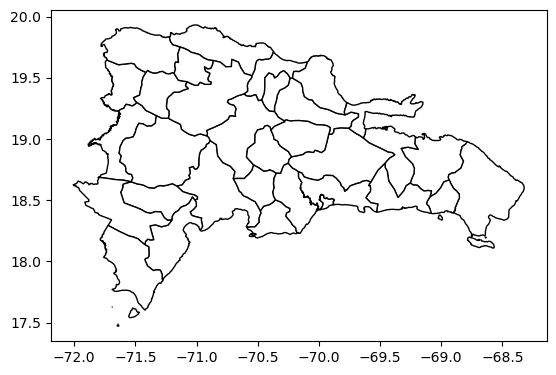

In [74]:
import matplotlib.pyplot as plt
import os

os.environ["SHAPE_RESTORE_SHX"] = "YES"

dominicana_map = gpd.read_file('./data/dominicanrepublicgeojson.shp')

print(dominicana_map.head())

fig, ax = plt.subplots()
dominicana_map.plot(ax=ax, color='white', edgecolor='black')